In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import plotly.express as px

In [2]:
ptc = pd.read_csv('pathToConversion.csv')  
csm = pd.read_csv('channelSourceMedium.csv')  
allC = pd.read_csv('allChannels.csv')  

# prelim notes
- assumptions: online only store, mainly on website
- invest in tracking for time series data -- see trends in more depth than in yearly 3 month blocks 
- get data on how many leads are lost at a given time to see if marketing efforts are working in addition to conversion and bounce rate, to potentially see what is causing people to leave (e.g. less spending power due to pandemic/more spending on sporting goods as people try to exercise at home)
- get social media data (see if target demographic is reached, and if this generates more leads as well as how many leads are lost at a given time)

# path to conversion

In [3]:
#remove currency (A$) from conversion value
ptc['Conversion Value'] = ptc['Conversion Value'].apply(lambda x: x[2:])
ptc.head()

#remove all commas from numerics 
ptc = ptc.replace(',','', regex=True)

#convert to numeric
ptc[["Conversions", "Conversion Value"]] = ptc[["Conversions", "Conversion Value"]].apply(pd.to_numeric)

In [4]:
ptc.head()

,MCF Channel Grouping Path,Date Range,Conversions,Conversion Value
0,Organic Search,Aug 1 2020 - Oct 31 2020,6414,273584.28
1,Organic Search,Aug 1 2019 - Oct 31 2019,3757,89015.73
2,Paid Search,Aug 1 2020 - Oct 31 2020,6132,255676.86
3,Paid Search,Aug 1 2019 - Oct 31 2019,13,49.94
4,Direct,Aug 1 2020 - Oct 31 2020,4920,235247.46


In [5]:
ptc.describe()

,Conversions,Conversion Value
count,500.000000,340.000000
mean,98.384000,6174.381353
std,511.671128,25847.900285
min,0.000000,33.940000
25%,0.000000,449.577500
50%,12.000000,917.380000
75%,28.000000,2624.185000
max,6414.000000,273584.280000


In [6]:
ptc.groupby(by="Date Range").sum ()

,Conversions,Conversion Value
Date Range,,
Aug 1 2019 - Oct 31 2019,11151,333990.20
Aug 1 2020 - Oct 31 2020,38041,1765299.46


In [7]:
#split df into number of steps taken in path (more than one step vs single step paths)
multistepIndex = (ptc.index[ptc['MCF Channel Grouping Path'].str.contains('>')].tolist())
multistep = ptc.loc[ptc.index[multistepIndex]]
singlestep = ptc.loc[ptc.index.difference(multistep.index)]

In [8]:
print(len(singlestep))
print(len(multistep))

14
486


In [9]:
#sum of conversions and vlaue for single and multiple step conversion
multiSum = multistep.groupby(by="Date Range").sum ()
singleSum = singlestep.groupby(by="Date Range").sum()

In [10]:
multiSum

,Conversions,Conversion Value
Date Range,,
Aug 1 2019 - Oct 31 2019,4303,160022.3
Aug 1 2020 - Oct 31 2020,19130,933512.7


In [11]:
singleSum

,Conversions,Conversion Value
Date Range,,
Aug 1 2019 - Oct 31 2019,6848,173967.90
Aug 1 2020 - Oct 31 2020,18911,831786.76


In [12]:
# 2020 multi step increase
((19130-18911)/18911)*100

1.1580561577917614

In [13]:
#single step increase
((6848-4303)/4303)*100

59.1447827097374

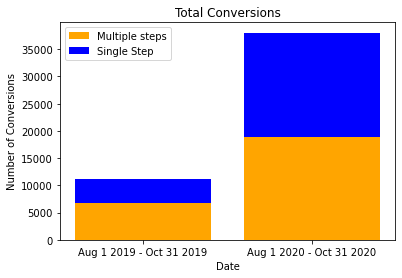

In [14]:
#comparing total conversions for the business and how much each type of conversion contributed
x = ['Aug 1 2019 - Oct 31 2019', 'Aug 1 2020 - Oct 31 2020']
single = singleSum['Conversions']
multi = multiSum['Conversions']
  
plt.bar(x, single, color='orange')
plt.bar(x, multi, bottom=single, color='blue')
plt.xlabel("Date")
plt.ylabel("Number of Conversions")
plt.legend(["Multiple steps", "Single Step"])
plt.title("Total Conversions")
plt.show()

In [15]:
#get first step in path
pathFirst = []
for a, b in multistep.iterrows():
    txt = b["MCF Channel Grouping Path"]
    first = txt.split(' ', 1)[0]
    
    first = first.strip()
    pathFirst.append(first)
len(pathFirst)


#append first step to path
multistep.insert(1, "First Step", pathFirst, True)
multistep.head()

,MCF Channel Grouping Path,First Step,Date Range,Conversions,Conversion Value
6,Organic Search > Direct,Organic,Aug 1 2020 - Oct 31 2020,1925,80225.36
7,Organic Search > Direct,Organic,Aug 1 2019 - Oct 31 2019,880,28012.70
8,Direct > Direct,Direct,Aug 1 2020 - Oct 31 2020,1423,84578.33
9,Direct > Direct,Direct,Aug 1 2019 - Oct 31 2019,435,14951.39
10,Paid Search > Paid Search,Paid,Aug 1 2020 - Oct 31 2020,1234,56194.65


In [16]:
#get last step in path -- default channel grouping
pathLast = []
for i, j in multistep.iterrows():
    txt = j["MCF Channel Grouping Path"]
    last = txt[txt.rindex('>')+1:]
    last = last.strip()
    pathLast.append(last)
len(pathLast)

#append last step to path
multistep.insert(2, "Last Step", pathLast, True)
multistep

,MCF Channel Grouping Path,First Step,Last Step,Date Range,Conversions,Conversion Value
6,Organic Search > Direct,Organic,Direct,Aug 1 2020 - Oct 31 2020,1925,80225.36
7,Organic Search > Direct,Organic,Direct,Aug 1 2019 - Oct 31 2019,880,28012.70
8,Direct > Direct,Direct,Direct,Aug 1 2020 - Oct 31 2020,1423,84578.33
9,Direct > Direct,Direct,Direct,Aug 1 2019 - Oct 31 2019,435,14951.39
10,Paid Search > Paid Search,Paid,Paid Search,Aug 1 2020 - Oct 31 2020,1234,56194.65
...,...,...,...,...,...,...
495,Paid Search > Direct > Direct > Paid Search > ...,Paid,Paid Search,Aug 1 2019 - Oct 31 2019,0,NaN
496,Paid Search > Direct > Direct > Paid Search > ...,Paid,Direct,Aug 1 2020 - Oct 31 2020,8,191.90
497,Paid Search > Direct > Direct > Paid Search > ...,Paid,Direct,Aug 1 2019 - Oct 31 2019,0,NaN
498,Paid Search > Direct > Direct > Organic Search...,Paid,Direct,Aug 1 2020 - Oct 31 2020,8,449.96


In [17]:
multistep['First Step'].value_counts()

Paid             196
Organic          106
Direct           100
Email             64
Social             8
Referral           8
(unavailable)      4
Name: First Step, dtype: int64

In [18]:
multistep['Last Step'].value_counts()

Direct            214
Paid Search       114
Referral           58
Organic Search     52
Email              42
Social Network      4
(unavailable)       2
Name: Last Step, dtype: int64

In [19]:
multistep['Last Step'].unique()

array(['Direct', 'Paid Search', 'Organic Search', 'Referral', 'Email',
       'Social Network', '(unavailable)'], dtype=object)

In [20]:
#combine data to see where people commonly start their path vs what gets them to convert
stepData = {'Grouping':['Direct', 'Paid Search', 'Organic Search', 'Referral','Email',
       'Social Network', '(unavailable)'],
        'First':[100, 196, 106,  8, 64, 8, 4],
        'Last':[214, 114, 52, 58, 42, 4, 2]}
 
multiGrouping = pd.DataFrame(stepData)
multiGrouping

,Grouping,First,Last
0,Direct,100,214
1,Paid Search,196,114
2,Organic Search,106,52
3,Referral,8,58
4,Email,64,42
5,Social Network,8,4
6,(unavailable),4,2


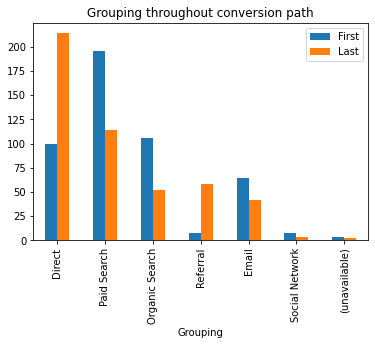

In [21]:
#distribution of channels that led to conversion vs what started journey
multiGrouping.plot(x='Grouping',
        kind='bar',
        stacked=False,
        title='Grouping throughout conversion path')
plt.show()

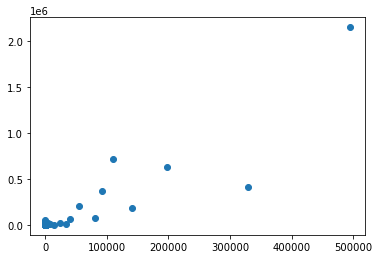

In [22]:
plt.scatter(csm['New Users'], csm['Revenue'])
plt.show()

In [23]:
singlestep

,MCF Channel Grouping Path,Date Range,Conversions,Conversion Value
0,Organic Search,Aug 1 2020 - Oct 31 2020,6414,273584.28
1,Organic Search,Aug 1 2019 - Oct 31 2019,3757,89015.73
2,Paid Search,Aug 1 2020 - Oct 31 2020,6132,255676.86
3,Paid Search,Aug 1 2019 - Oct 31 2019,13,49.94
4,Direct,Aug 1 2020 - Oct 31 2020,4920,235247.46
5,Direct,Aug 1 2019 - Oct 31 2019,1821,51037.46
12,Email,Aug 1 2020 - Oct 31 2020,1058,43927.35
13,Email,Aug 1 2019 - Oct 31 2019,377,12476.85
52,Referral,Aug 1 2020 - Oct 31 2020,181,11005.85
53,Referral,Aug 1 2019 - Oct 31 2019,89,3432.67


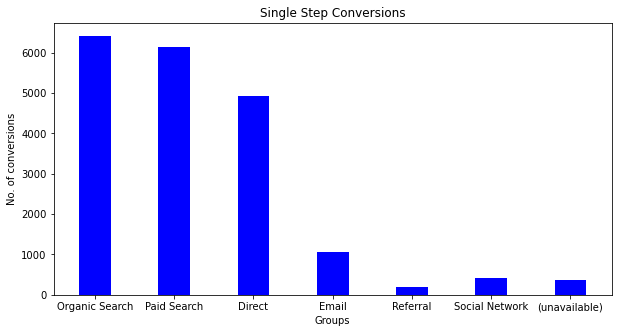

In [24]:
groups = singlestep['MCF Channel Grouping Path']
values = singlestep['Conversions']
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(groups, values, color ='blue',
        width = 0.4)
 
plt.xlabel("Groups")
plt.ylabel("No. of conversions")
plt.title("Single Step Conversions")
plt.show()

# analysis: conversion paths

### what was done
- Split to single step vs multi step
- Only take the last step from multi step (this is the channel that caused conversion)
- Compare value of conversion to see where efforts can be focused towards

### what was found 
- most conversion revenue from 2020 period
- single step higher in 2019, multi step in 2020
- email and referral are efforts that have shown results in terms of getting people to convert after multiple steps 

- both single and multi-step conversion has the least amount of revenue from social network
- single step: people know what they want (SEO works well since most revenue comes from organic search)
- multi-step:  they mainly start at paid search, but they convert at direct (customers are seeing the items from paid search, but eventually they head to the item directly)

### what can be done 
- if known what marketing changes were made btw 2019 and 2020, can evaluate what caused people to turn the number of conversions (single or multi) to over double its number in 2019 
- invest in email tracking (how many moved to spam, how many read, etc -- like hubspot mail tracking) to see if email is effective in converting customers actively from the company side
- additional information on email campaign and whether or not their target audience were those who went through with a transaction
- since budget is limited, email might be a good channel to start increasing focus on while maintaining existing efforts. though tough to say which efforts are to be kept since not much info on that is available) 


# channel source medium

In [25]:
csm.head()

,Default Channel Grouping,Source / Medium,Date Range,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
0,Organic Search,google / organic,"Aug 1, 2020 - Oct 31, 2020",221784.0,197746.0,296409.0,46.97%,3.26,190.14,1.19%,3527.0,628987.70
1,Organic Search,google / organic,"Aug 1, 2019 - Oct 31, 2019",158190.0,141089.0,224384.0,32.84%,4.66,230.97,0.52%,1168.0,186796.74
2,Paid Search,google / cpc,"Aug 1, 2020 - Oct 31, 2020",131294.0,109944.0,215401.0,51.46%,3.18,168.79,1.77%,3803.0,716210.62
3,Paid Search,google / cpc,"Aug 1, 2019 - Oct 31, 2019",320.0,299.0,390.0,32.31%,5.54,173.54,0.00%,0.0,0.00
4,Direct,(direct) / (none),"Aug 1, 2020 - Oct 31, 2020",92694.0,91224.0,126871.0,47.98%,3.44,194.03,1.42%,1796.0,368520.82


In [26]:
#remove null values
csm = csm[csm['Source / Medium'].notna()]
csm.dtypes

Default Channel Grouping      object
Source / Medium               object
Date Range                    object
Users                        float64
New Users                    float64
Sessions                     float64
Bounce Rate                   object
Pages / Session              float64
Avg. Session Duration        float64
Ecommerce Conversion Rate     object
Transactions                 float64
Revenue                      float64
dtype: object

In [27]:
#remove percentage
csm['Bounce Rate'] =csm['Bounce Rate'].apply(lambda x: x[:-1])
csm['Ecommerce Conversion Rate'] =csm['Ecommerce Conversion Rate'].apply(lambda x: x[:-1])
#convert to numeric
csm[["Bounce Rate", "Ecommerce Conversion Rate"]] = csm[["Bounce Rate", "Ecommerce Conversion Rate"]].apply(pd.to_numeric)
csm.head()

,Default Channel Grouping,Source / Medium,Date Range,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
0,Organic Search,google / organic,"Aug 1, 2020 - Oct 31, 2020",221784.0,197746.0,296409.0,46.97,3.26,190.14,1.19,3527.0,628987.70
1,Organic Search,google / organic,"Aug 1, 2019 - Oct 31, 2019",158190.0,141089.0,224384.0,32.84,4.66,230.97,0.52,1168.0,186796.74
2,Paid Search,google / cpc,"Aug 1, 2020 - Oct 31, 2020",131294.0,109944.0,215401.0,51.46,3.18,168.79,1.77,3803.0,716210.62
3,Paid Search,google / cpc,"Aug 1, 2019 - Oct 31, 2019",320.0,299.0,390.0,32.31,5.54,173.54,0.00,0.0,0.00
4,Direct,(direct) / (none),"Aug 1, 2020 - Oct 31, 2020",92694.0,91224.0,126871.0,47.98,3.44,194.03,1.42,1796.0,368520.82


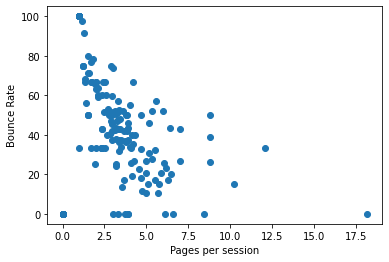

In [28]:
#correlation between New Users and transaction

plt.scatter(csm['Pages / Session'], csm['Bounce Rate'])
plt.xlabel("Pages per session")
plt.ylabel("Bounce Rate")

plt.show()


In [29]:
csm.groupby(by="Date Range").sum().sort_values(by="Revenue", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Date Range,,,,,,,,,
"Aug 1, 2020 - Oct 31, 2020",564170.0,494467.0,847768.0,4634.66,325.08,19695.25,252.11,11320.0,2154497.91
"Aug 1, 2019 - Oct 31, 2019",363024.0,321829.0,539267.0,2304.09,213.97,10462.20,61.98,2322.0,365965.68


In [30]:
#explore what has large std, find what causes large variability in numbers
#observed in: users, new users, transactions, ecomm conversion, revenue
csm.describe()

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4635.970000,4081.480000,6935.175000,34.693750,2.695250,150.787250,1.570450,68.210000,12602.317950
std,23722.454011,21152.074414,34487.917543,29.796269,2.529393,187.695921,5.496952,401.983119,74639.456595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.250000,0.000000,2.250000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,9.000000,21.000000,33.960000,2.560000,110.910000,0.000000,0.000000,0.000000
75%,79.000000,44.000000,106.000000,51.922500,3.890000,210.922500,0.122500,3.000000,139.220000
max,221784.000000,197746.000000,296409.000000,100.000000,18.170000,1350.170000,50.240000,3803.000000,716210.620000


In [31]:
csm.groupby(by="Default Channel Grouping").sum().sort_values(by="Bounce Rate", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Default Channel Grouping,,,,,,,,,
Referral,5125.0,3184.0,7302.0,3930.85,355.46,21314.50,269.64,642.0,139432.74
Other Advertising,45562.0,37606.0,67316.0,1274.45,58.61,3059.48,2.73,129.0,18998.79
Social,34168.0,26658.0,50056.0,681.54,36.19,1485.98,3.14,223.0,38884.11
Organic Search,390129.0,347666.0,534185.0,638.54,56.25,2685.67,29.44,4881.0,841177.55
Paid Search,161791.0,135343.0,258525.0,202.38,19.53,938.35,6.13,4087.0,763220.09
Email,114997.0,94202.0,237983.0,111.02,5.97,322.94,1.07,1344.0,270722.93
Direct,175422.0,171637.0,231668.0,99.97,7.04,350.53,1.94,2336.0,448027.38


In [32]:
csm.groupby(by="Default Channel Grouping").sum().sort_values(by="New Users", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Default Channel Grouping,,,,,,,,,
Organic Search,390129.0,347666.0,534185.0,638.54,56.25,2685.67,29.44,4881.0,841177.55
Direct,175422.0,171637.0,231668.0,99.97,7.04,350.53,1.94,2336.0,448027.38
Paid Search,161791.0,135343.0,258525.0,202.38,19.53,938.35,6.13,4087.0,763220.09
Email,114997.0,94202.0,237983.0,111.02,5.97,322.94,1.07,1344.0,270722.93
Other Advertising,45562.0,37606.0,67316.0,1274.45,58.61,3059.48,2.73,129.0,18998.79
Social,34168.0,26658.0,50056.0,681.54,36.19,1485.98,3.14,223.0,38884.11
Referral,5125.0,3184.0,7302.0,3930.85,355.46,21314.50,269.64,642.0,139432.74


In [33]:
csm.groupby(by="Default Channel Grouping").sum().sort_values(by="Transactions", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Default Channel Grouping,,,,,,,,,
Organic Search,390129.0,347666.0,534185.0,638.54,56.25,2685.67,29.44,4881.0,841177.55
Paid Search,161791.0,135343.0,258525.0,202.38,19.53,938.35,6.13,4087.0,763220.09
Direct,175422.0,171637.0,231668.0,99.97,7.04,350.53,1.94,2336.0,448027.38
Email,114997.0,94202.0,237983.0,111.02,5.97,322.94,1.07,1344.0,270722.93
Referral,5125.0,3184.0,7302.0,3930.85,355.46,21314.50,269.64,642.0,139432.74
Social,34168.0,26658.0,50056.0,681.54,36.19,1485.98,3.14,223.0,38884.11
Other Advertising,45562.0,37606.0,67316.0,1274.45,58.61,3059.48,2.73,129.0,18998.79


In [34]:
csm.groupby(by="Default Channel Grouping").sum().sort_values(by="Ecommerce Conversion Rate", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Default Channel Grouping,,,,,,,,,
Referral,5125.0,3184.0,7302.0,3930.85,355.46,21314.50,269.64,642.0,139432.74
Organic Search,390129.0,347666.0,534185.0,638.54,56.25,2685.67,29.44,4881.0,841177.55
Paid Search,161791.0,135343.0,258525.0,202.38,19.53,938.35,6.13,4087.0,763220.09
Social,34168.0,26658.0,50056.0,681.54,36.19,1485.98,3.14,223.0,38884.11
Other Advertising,45562.0,37606.0,67316.0,1274.45,58.61,3059.48,2.73,129.0,18998.79
Direct,175422.0,171637.0,231668.0,99.97,7.04,350.53,1.94,2336.0,448027.38
Email,114997.0,94202.0,237983.0,111.02,5.97,322.94,1.07,1344.0,270722.93


In [35]:
csm.groupby(by="Default Channel Grouping").mean().sort_values(by="Pages / Session", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Default Channel Grouping,,,,,,,,,
Direct,87711.000000,85818.500000,115834.000000,49.985000,3.520000,175.265000,0.970000,1168.000000,224013.690000
Organic Search,24383.062500,21729.125000,33386.562500,39.908750,3.515625,167.854375,1.840000,305.062500,52573.596875
Paid Search,26965.166667,22557.166667,43087.500000,33.730000,3.255000,156.391667,1.021667,681.166667,127203.348333
Email,57498.500000,47101.000000,118991.500000,55.510000,2.985000,161.470000,0.535000,672.000000,135361.465000
Referral,41.330645,25.677419,58.887097,31.700403,2.866613,171.891129,2.174516,5.177419,1124.457581
Social,2440.571429,1904.142857,3575.428571,48.681429,2.585000,106.141429,0.224286,15.928571,2777.436429
Other Advertising,1265.611111,1044.611111,1869.888889,35.401389,1.628056,84.985556,0.075833,3.583333,527.744167


In [36]:
bounceRateMean = csm.groupby(by="Default Channel Grouping").mean().sort_values(by="Bounce Rate", ascending=False)
bounceRateMean

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Default Channel Grouping,,,,,,,,,
Email,57498.500000,47101.000000,118991.500000,55.510000,2.985000,161.470000,0.535000,672.000000,135361.465000
Direct,87711.000000,85818.500000,115834.000000,49.985000,3.520000,175.265000,0.970000,1168.000000,224013.690000
Social,2440.571429,1904.142857,3575.428571,48.681429,2.585000,106.141429,0.224286,15.928571,2777.436429
Organic Search,24383.062500,21729.125000,33386.562500,39.908750,3.515625,167.854375,1.840000,305.062500,52573.596875
Other Advertising,1265.611111,1044.611111,1869.888889,35.401389,1.628056,84.985556,0.075833,3.583333,527.744167
Paid Search,26965.166667,22557.166667,43087.500000,33.730000,3.255000,156.391667,1.021667,681.166667,127203.348333
Referral,41.330645,25.677419,58.887097,31.700403,2.866613,171.891129,2.174516,5.177419,1124.457581


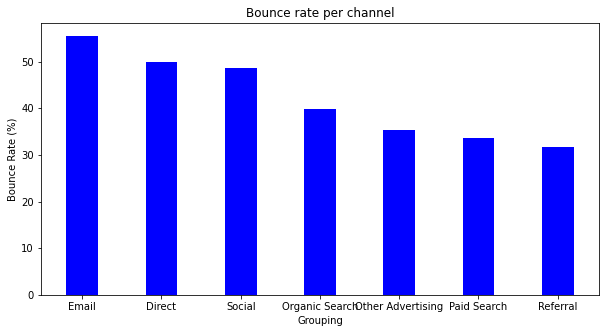

In [37]:
group = bounceRateMean.index
bounceRate = bounceRateMean['Bounce Rate']
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(group, bounceRate, color ='blue',
        width = 0.4)
 
plt.xlabel("Grouping")
plt.ylabel("Bounce Rate (%)")
plt.title("Bounce rate per channel")
plt.show()

In [38]:
#analysing csm['Source / Medium']
csm['Source / Medium']

0                    google / organic
1                    google / organic
2                        google / cpc
3                        google / cpc
4                   (direct) / (none)
                    ...              
195    accounts.google.com / referral
196       app.limespot.com / referral
197       app.limespot.com / referral
198      emoji.srchmbl.com / referral
199      emoji.srchmbl.com / referral
Name: Source / Medium, Length: 200, dtype: object

In [39]:
#split source/medium 
source = []
for a, b in csm.iterrows():
    txt = b["Source / Medium"]
    first = txt.split(' ', 1)[0]
    first = first.strip()
    source.append(first)

medium = []
for i, j in csm.iterrows():
    txt = j["Source / Medium"]
    last = txt[txt.rindex('/')+1:]
    last = last.strip()
    medium.append(last)

In [40]:
#get top level domain of referral source
splitSource = []
for i in source:
    split = i.split(".", 4)
    splitSource.append(split)
splitSource

[['google'],
 ['google'],
 ['google'],
 ['google'],
 ['(direct)'],
 ['(direct)'],
 ['email'],
 ['email'],
 ['facebook'],
 ['facebook'],
 ['facebook', 'com'],
 ['facebook', 'com'],
 ['bing'],
 ['bing'],
 ['email'],
 ['email'],
 ['bing'],
 ['bing'],
 ['facebook'],
 ['facebook'],
 ['zip'],
 ['zip'],
 ['yahoo'],
 ['yahoo'],
 ['humm'],
 ['humm'],
 ['facebook'],
 ['facebook'],
 ['shoppings', 'com', 'au'],
 ['shoppings', 'com', 'au'],
 ['duckduckgo'],
 ['duckduckgo'],
 ['au', 'search', 'yahoo', 'com'],
 ['au', 'search', 'yahoo', 'com'],
 ['shop_app'],
 ['shop_app'],
 ['shop', 'app'],
 ['shop', 'app'],
 ['ecosia', 'org'],
 ['ecosia', 'org'],
 ['igshopping'],
 ['igshopping'],
 ['coupon', 'com'],
 ['coupon', 'com'],
 ['social'],
 ['social'],
 ['shoppingfield', 'com', 'au'],
 ['shoppingfield', 'com', 'au'],
 ['instagram', 'com'],
 ['instagram', 'com'],
 ['kickkicksaustralia', 'com', 'au'],
 ['kickkicksaustralia', 'com', 'au'],
 ['mail', 'google', 'com'],
 ['mail', 'google', 'com'],
 ['social'],
 

In [41]:
#get top level domain name
def remove(L):
    L.remove('com')
    L.remove('au')
    L.remove('net')
    L.remove('org')
    L.remove('io')
    L.remove('app')
    return(L)
        
for L in splitSource:
    try:
        remove(L)
    except ValueError:
        pass

In [51]:
#get frequency for domain
Output = {}
for lis in splitSource:
    Output.setdefault(tuple(lis), list()).append(1)
for a, b in Output.items():
    Output[a] = sum(b)

In [43]:
srcFreq = pd.DataFrame(Output.items(), columns=['src', 'freq'])
srcFreq

,src,freq
0,"(google,)",10
1,"((direct),)",2
2,"(email,)",8
3,"(facebook,)",14
4,"(bing,)",4
...,...,...
74,"(email,email,)",2
75,"(email),)",2
76,"(accounts, google)",2
77,"(app, limespot)",2


In [44]:
#get top 10 domains
top10src = srcFreq.sort_values(by=['freq'], ascending=False).head(10)
top10src

,src,freq
3,"(facebook,)",14
0,"(google,)",10
2,"(email,)",8
7,"(humm,)",6
16,"(social,)",6
4,"(bing,)",4
41,"(pinterest,)",4
48,"(info,)",4
18,"(instagram,)",4
53,"(indeed,)",2


In [45]:
#strip tuple values to only domain name
top10src['src'] = top10src['src'].apply(lambda x: re.sub('[^A-Za-z0-9]', '', str(x)))
top10src

,src,freq
3,facebook,14
0,google,10
2,email,8
7,humm,6
16,social,6
4,bing,4
41,pinterest,4
48,info,4
18,instagram,4
53,indeed,2


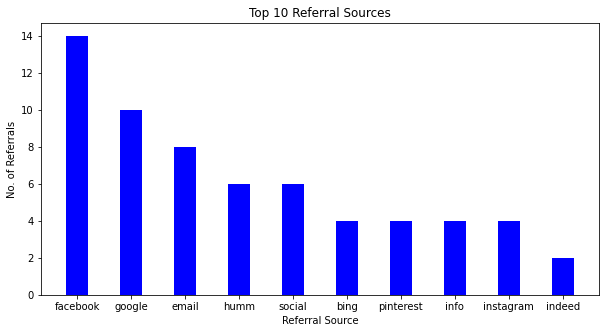

In [46]:
#visualising top 10 domains contributing to referrals
src = top10src['src']
freq = top10src['freq']
  
fig = plt.figure(figsize = (10, 5))

plt.bar(src, freq, color ='blue',
        width = 0.4)
 
plt.xlabel("Referral Source")
plt.ylabel("No. of Referrals")
plt.title("Top 10 Referral Sources")
plt.show()

# analysis: channel source medium
*visualisations are not done, following points are made from just the numbers 

### what was done
- use standard deviation to see what channels are bringing in the most variability and towards more/less success in terms of conversion and transaction
- sum was used instead of mean due to the large gap in values between 2019 and 2020 data

### what was found 
- high std in users, new users, transactions, ecomm conversion, revenue

- users are brought in mainly by organic search -- leading to the assumptions that that: 1. SEO is good, 2. the brand is known within the area (how jd sports is known in the melbourne area)
- not very high std in session time, leading us to believe that users interact with pages relatively similarly regardless of channel, and they are within the same few pages as the std for that is also relatively low 
- paid search brings highest revenue, but organic search yields the most transactions
- email is the leading effort under search augmentations in every metric with high variability except conversion, also yielding lowest bounce rate
- socials is the lowest except in conversion
- trends in effort beyond searches (email and social in particular) are the opposite of what was found in conversion path
- in this conversion data, the leading group is referral, but it has the highest bounce rate


### what can be done
- invest in tracking for time series data: can reveal whether the increase in users and sales are from improvements in SEO/more money in search, or from the fact that people know the brand more 


# all channels

In [47]:
allC.head()

,Default Channel Grouping,Date Range,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
0,Organic Search,"Aug 1, 2020 - Oct 31, 2020",222228,198663,297979,46.88%,3.28,192.93,1.17%,3498,637871.35
1,Organic Search,"Aug 1, 2019 - Oct 31, 2019",163455,149225,236981,32.77%,4.68,230.87,0.54%,1271,197960.23
2,Paid Search,"Aug 1, 2020 - Oct 31, 2020",156975,132216,254775,48.81%,3.24,177.00,1.51%,3835,723293.09
3,Paid Search,"Aug 1, 2019 - Oct 31, 2019",346,310,423,34.75%,5.41,173.36,0.47%,2,861.89
4,Direct,"Aug 1, 2020 - Oct 31, 2020",89935,88754,124707,48.04%,3.44,193.99,1.46%,1816,364765.93


In [48]:
#remove percentage
allC['Bounce Rate'] =allC['Bounce Rate'].apply(lambda x: x[:-1])
allC['Ecommerce Conversion Rate'] =allC['Ecommerce Conversion Rate'].apply(lambda x: x[:-1])
#convert to numeric
allC[["Bounce Rate", "Ecommerce Conversion Rate"]] = allC[["Bounce Rate", "Ecommerce Conversion Rate"]].apply(pd.to_numeric)
allC.head()

,Default Channel Grouping,Date Range,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
0,Organic Search,"Aug 1, 2020 - Oct 31, 2020",222228,198663,297979,46.88,3.28,192.93,1.17,3498,637871.35
1,Organic Search,"Aug 1, 2019 - Oct 31, 2019",163455,149225,236981,32.77,4.68,230.87,0.54,1271,197960.23
2,Paid Search,"Aug 1, 2020 - Oct 31, 2020",156975,132216,254775,48.81,3.24,177.00,1.51,3835,723293.09
3,Paid Search,"Aug 1, 2019 - Oct 31, 2019",346,310,423,34.75,5.41,173.36,0.47,2,861.89
4,Direct,"Aug 1, 2020 - Oct 31, 2020",89935,88754,124707,48.04,3.44,193.99,1.46,1816,364765.93


In [49]:
allC.describe()

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,1.600000e+01
mean,115650.500000,102599.375000,175714.750000,47.456875,3.583750,183.166250,1.371250,1687.750000,3.125200e+05
std,153728.465979,136530.921333,231171.920074,10.432222,0.796742,45.901671,2.132897,2747.557449,5.247481e+05
min,346.000000,310.000000,423.000000,32.770000,2.180000,99.140000,0.280000,2.000000,8.618900e+02
25%,7302.250000,4722.750000,10558.750000,38.747500,3.180000,169.237500,0.467500,180.000000,2.559887e+04
50%,57548.000000,47371.000000,106326.000000,48.035000,3.390000,184.085000,0.765000,558.500000,1.067900e+05
75%,158595.000000,136468.250000,241429.500000,51.367500,3.835000,195.612500,1.340000,2018.250000,3.769699e+05
max,549731.000000,484223.000000,835489.000000,73.820000,5.410000,277.470000,9.140000,10877.000000,2.086578e+06


In [50]:
allC.groupby(by="Date Range").sum().sort_values(by="Revenue", ascending=False)

,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration,Ecommerce Conversion Rate,Transactions,Revenue
Date Range,,,,,,,,,
"Aug 1, 2020 - Oct 31, 2020",1099462,968446,1670978,364.54,27.43,1597.06,17.05,21754,4173156.80
"Aug 1, 2019 - Oct 31, 2019",750946,673144,1140458,394.77,29.91,1333.60,4.89,5250,827163.28


# analysis: all channels

### what was done
- similar to channel source medium

### what was found 
- not much, this table is mainly a summary of information

### what can be done